In [63]:
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
import numpy as np
import pandas as pd
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = (14, 5)

In [64]:
filepath = '../database/songs/ML1.mp3'
window_length = 1024
hop_length = int(window_length/2)
time = 30

In [65]:
x, sr = librosa.load(filepath, sr=44100)
middle = int(x.shape[0]/2)
lower = int(middle - sr*time/2)
upper = int(middle + sr*time/2)
x = x[lower:upper]
ipd.Audio(x, rate=sr)

### Normalization -> not sure if songs should be normalized

In [75]:
x, sr = librosa.load(filepath, sr=44100)
x = x[lower:upper]
x_normalized = librosa.util.normalize(x)
x = x_normalized

In [76]:
sr #every 43ms audio sample is acquired

44100

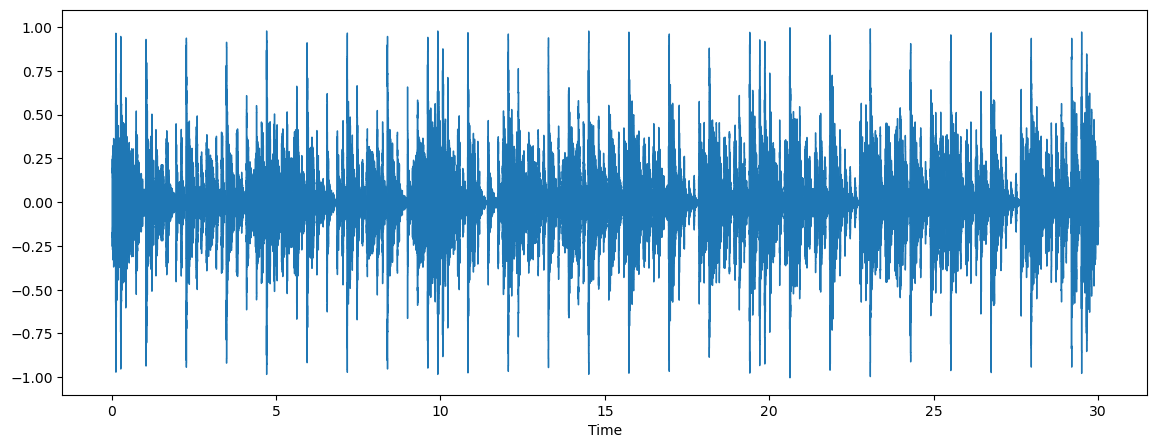

In [77]:
librosa.display.waveshow(y=x_normalized, sr=sr)

### Harmonic vs Percussive

Text(0.5, 1.0, 'Harmonic + Percussive')

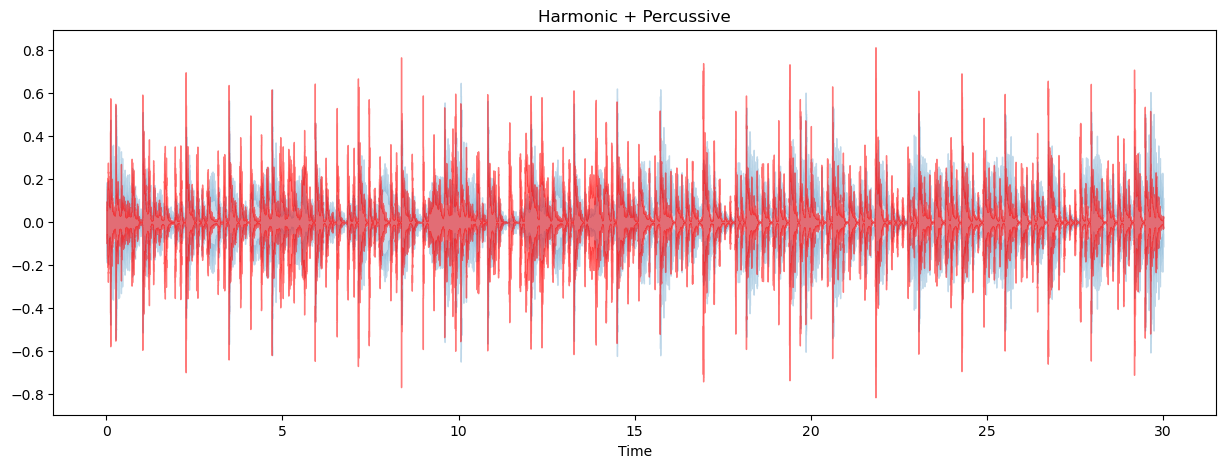

In [78]:
y_harmonic, y_percussive = librosa.effects.hpss(x)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')

# SPECTRAL

## 1.Extract spectral centroid

In [79]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr, hop_length=hop_length, win_length=window_length)[0]
spectral_centroids.shape

(2584,)

In [80]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

In [81]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

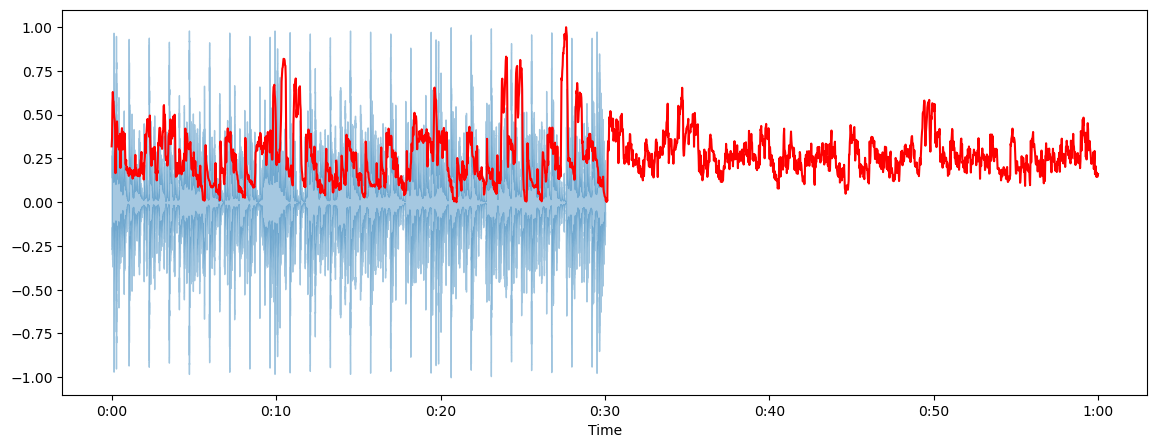

In [82]:
librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

In [83]:
spectral_centroids.reshape(1,spectral_centroids.shape[0]).shape

(1, 2584)

## //Extract spectral bandwidth

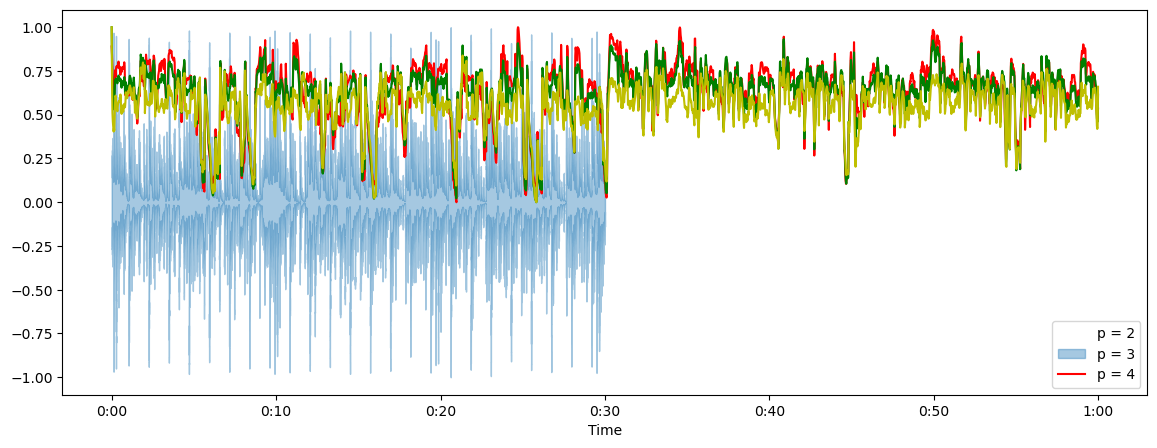

In [84]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=4)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

In [85]:
spectral_bandwidth_2.reshape(1,spectral_bandwidth_2.shape[0]).shape

(1, 2584)

## 2.Extract spectral rolloff

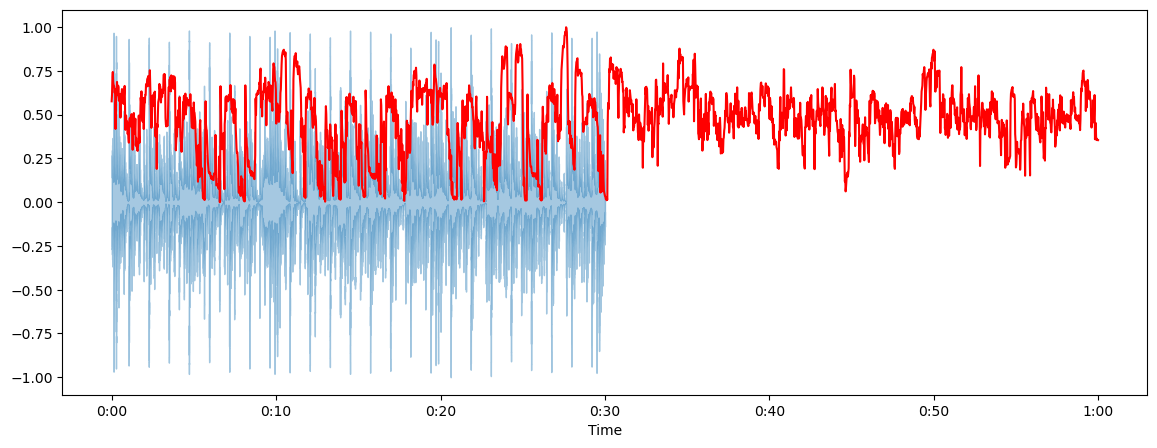

In [86]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, win_length=window_length, hop_length=hop_length)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

In [87]:
spectral_rolloff.reshape(1,spectral_rolloff.shape[0]).shape

(1, 2584)

## 3.Extract spectral flux

In [88]:
odf_default = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
onset_default = librosa.onset.onset_detect(y=x, sr=sr, hop_length=hop_length, units='time')
spectral_flux = odf_default

In [89]:
frame_time = librosa.frames_to_time(np.arange(len(odf_default)),
                                    sr=sr,
                                    hop_length=hop_length)


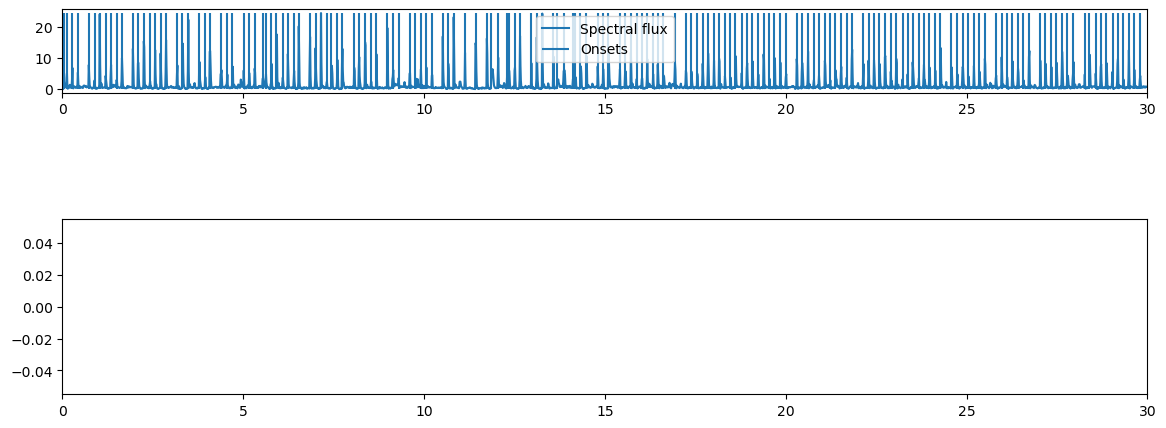

In [90]:
ax = plt.subplot(2, 1, 2)
plt.xlim([0, 30.0])
plt.axis('tight')

plt.subplot(4, 1, 1, sharex=ax)
plt.plot(frame_time, odf_default, label='Spectral flux')
plt.vlines(onset_default, 0, odf_default.max(), label='Onsets')
plt.legend()

In [91]:
odf_default.reshape(1,odf_default.shape[0]).shape

(1, 2584)

## 4.Extract spectral flatness

(1, 2584)

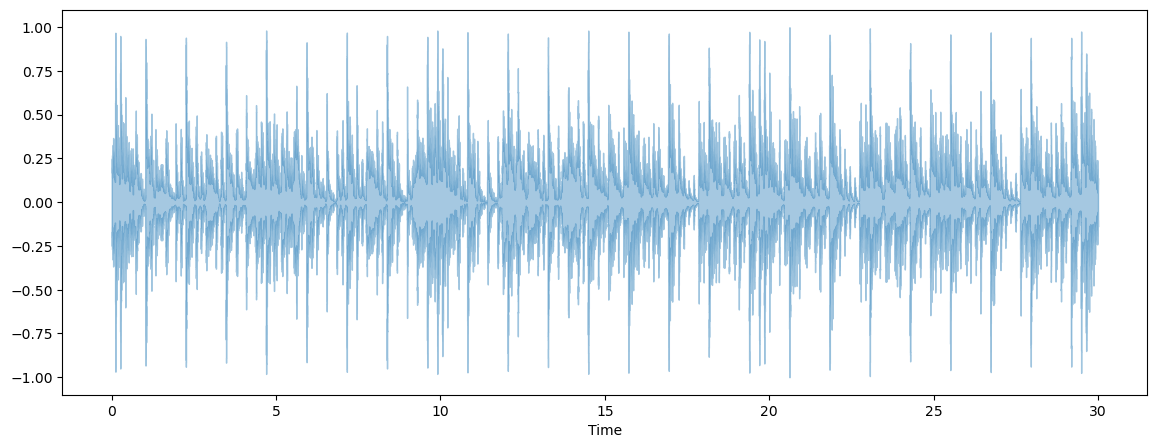

In [92]:
spectral_flatness = librosa.feature.spectral_flatness(y=x, hop_length=hop_length, win_length=window_length)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
spectral_flatness.reshape(1,spectral_flatness.shape[0]).shape

## //Extract spectral contrast

In [93]:
S = np.abs(librosa.stft(x))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

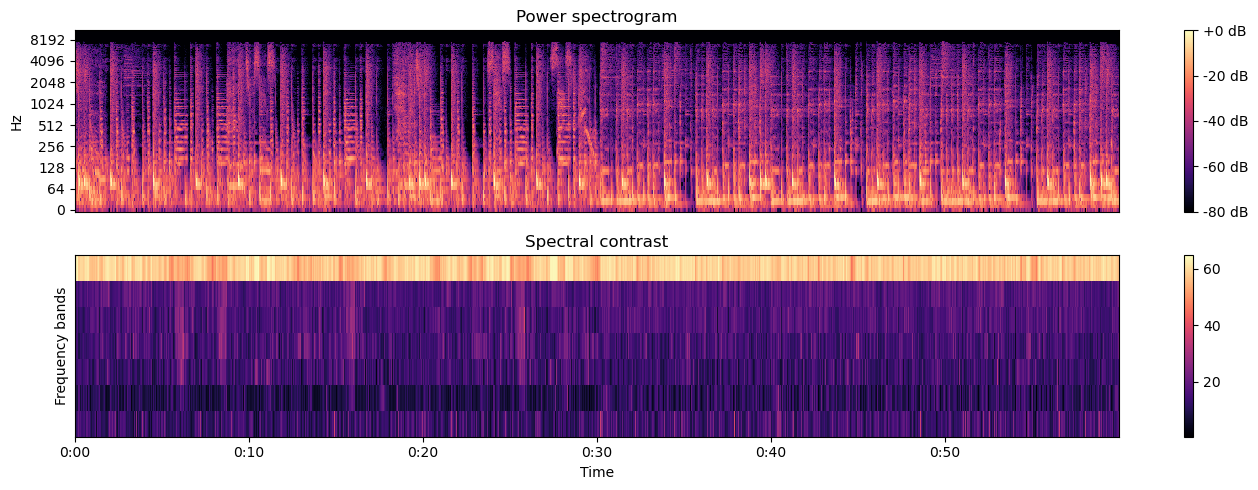

In [94]:
plt.figure()
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')
plt.tight_layout()

In [95]:
contrast.shape

(7, 2584)

# MFCC

## Extract melspectogram

In [96]:
mfcc_features_nb = 20

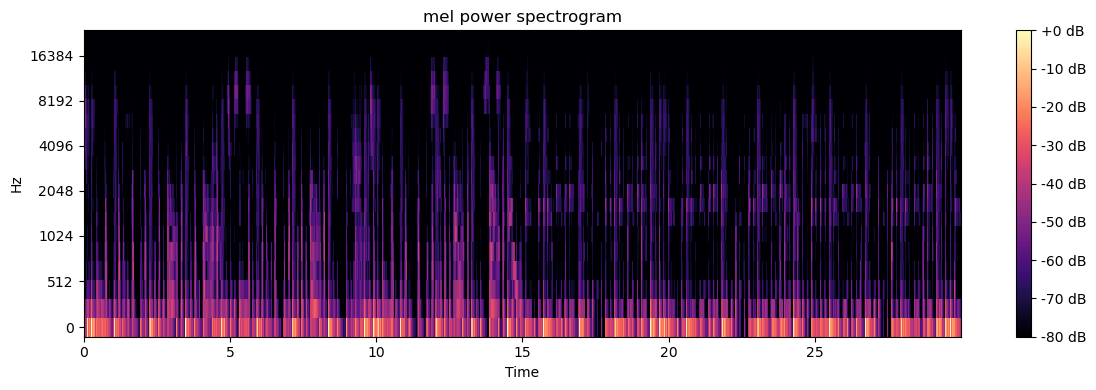

In [97]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=mfcc_features_nb)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.amplitude_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

Text(0.5, 1.0, 'MFCC')

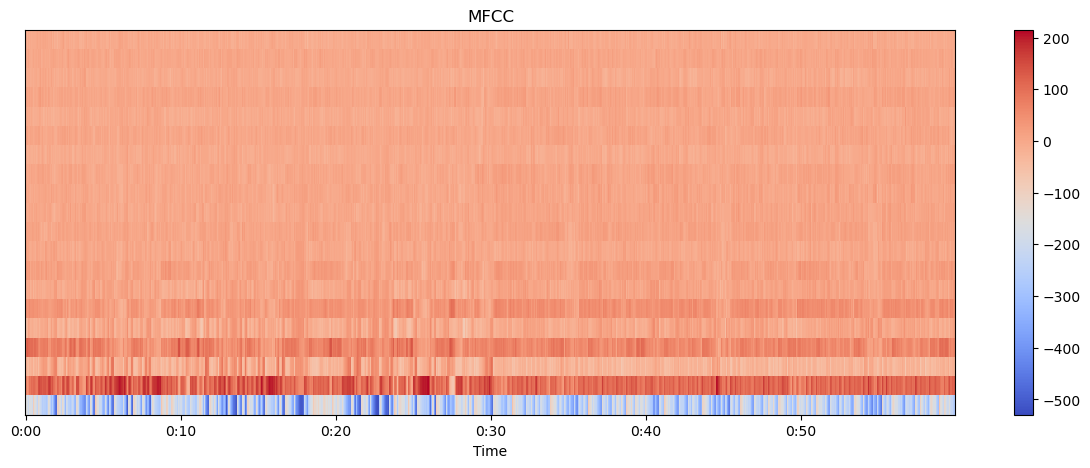

In [98]:
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=mfcc_features_nb, hop_length=hop_length, win_length=window_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

In [99]:
mfccs.shape

(20, 2584)

# Chromagram

## 6.Extract chromagram

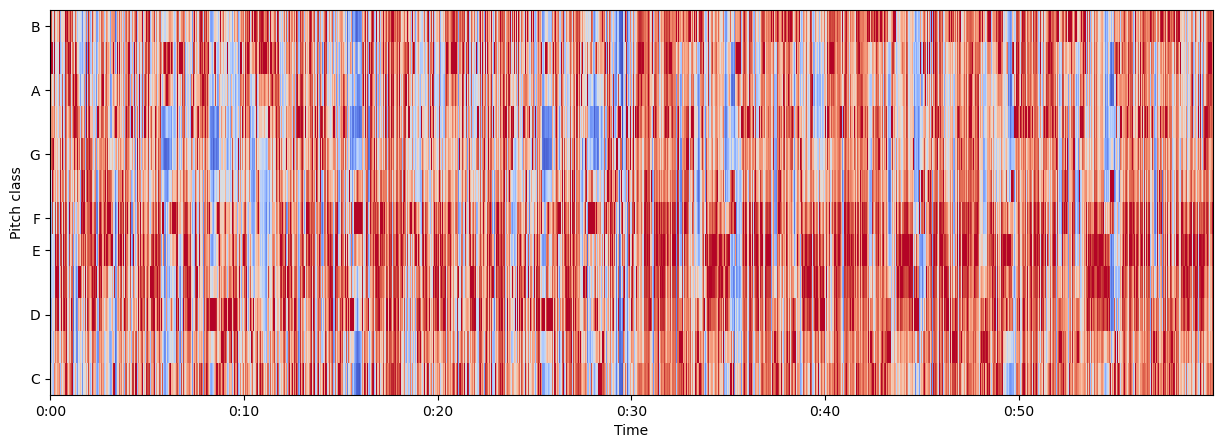

In [100]:
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length, win_length=window_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [101]:
chromagram.shape

(12, 2584)

# OCS

## 7.Extract octave-based spectral contrast

Text(0.5, 1.0, 'Spectral contrast')

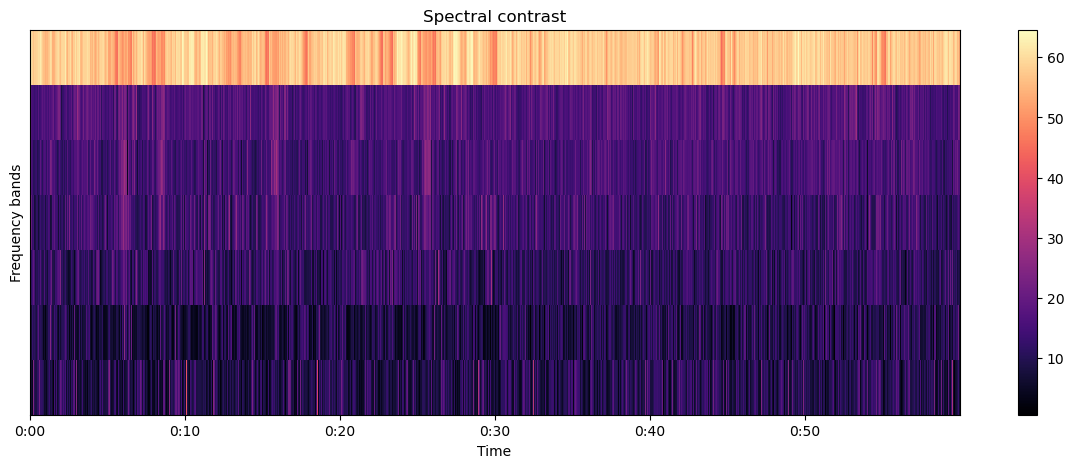

In [102]:
contrast=librosa.feature.spectral_contrast(y=x,sr=sr, hop_length=hop_length, win_length=window_length)
plt.figure(figsize=(15,5))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')

In [103]:
contrast

array([[ 6.63656381, 24.31616077,  9.28227723, ..., 12.79051747,
        10.70886341,  6.08283629],
       [ 8.61453343,  3.96961762, 14.65054645, ..., 21.32719859,
        16.06407022,  5.36502917],
       [13.18893428,  7.5969621 , 13.4002577 , ...,  9.66181493,
        13.89513259,  8.45765012],
       ...,
       [11.65759687, 14.66869462, 13.54395684, ..., 16.51999819,
        14.10041594, 16.44579672],
       [13.99977769, 14.70607854, 15.85380481, ..., 22.53237588,
        19.32070377, 21.75931207],
       [15.65934699, 58.93704845, 62.79624899, ..., 56.27112889,
        54.89507307, 52.75677377]])

## Extract 4 sharpness features

In [104]:
import timbral_models
fname = '../database/songs/ML2.mp3'
sharpness = timbral_models.timbral_sharpness(fname)
roughness = timbral_models.timbral_roughness(fname)
brightness = timbral_models.timbral_brightness(fname)
booming = timbral_models.timbral_booming(fname)

## Extract skewness and kurtosis

In [105]:
freqs = np.fft.fftfreq(x.size)
skew = scipy.stats.skew(freqs)
kurt = scipy.stats.kurtosis(freqs)

# Feature generation

In [106]:
def generate_mean_std_skew(data):
    mean=np.mean(data)
    std=np.std(data)
    skew=scipy.stats.skew(data,axis=0)
    return mean, std, skew

In [107]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [108]:
collist_centroids=['cent_mean','cent_std','cent_skew']
collist_rolloff=['rolloff_mean','rolloff_std','rolloff_skew']
collist_flux = ['flux_mean','flux_std','flux_skew']
collist_flatness=['flatness_mean','flatness_std','flatness_skew']
all_spect_columns = collist_centroids+collist_rolloff+collist_flux+collist_flatness

## Spectral centroid, rolloff, flux, flatness

In [109]:
spectral_dict = {}
features = [spectral_centroids, spectral_rolloff, spectral_flux, spectral_flatness]
j=0
for feature in features:
    mss = generate_mean_std_skew(feature)
    for i in range(0,3):
        spectral_dict[all_spect_columns[i+j]] = [mss[i]]
    j += 3
spectral_df = pd.DataFrame(data=spectral_dict)
spectral_df

cent_mean     cent_std  cent_skew  rolloff_mean  rolloff_std  \
0  2988.446644  1418.981695   1.311317   6419.627848  2460.956833   

   rolloff_skew  flux_mean  flux_std  flux_skew  flatness_mean  flatness_std  \
0     -0.423292   1.540393   2.60695   3.786716       0.000069      0.000243   

   flatness_skew  
0       38.77329

## MFCC

In [110]:
mfccs_mean=np.mean(mfccs,axis=1)
mfccs_std=np.std(mfccs,axis=1)
mfccs_df=pd.DataFrame()
for i in range(0,mfcc_features_nb):
    mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
for i in range(0,mfcc_features_nb):
    mfccs_df['mfccs_std_'+str(i)]=mfccs_std[i]
    
mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
mfccs_df

mfccs_mean_0  mfccs_mean_1  mfccs_mean_2  mfccs_mean_3  mfccs_mean_4  \
0   -244.796173    110.702858    -13.748219      61.86694     -0.781949   

   mfccs_mean_5  mfccs_mean_6  mfccs_mean_7  mfccs_mean_8  mfccs_mean_9  ...  \
0     36.989792      5.302571      13.06591      0.433678      7.750262  ...   

   mfccs_std_10  mfccs_std_11  mfccs_std_12  mfccs_std_13  mfccs_std_14  \
0      9.365755      9.474449      9.693264      8.216799      7.900067   

   mfccs_std_15  mfccs_std_16  mfccs_std_17  mfccs_std_18  mfccs_std_19  
0      8.577685      8.336209      8.364842      6.956614       6.62339  

[1 rows x 40 columns]

## OCS

In [111]:
contrast_mean=np.mean(contrast,axis=1)
contrast_std=np.std(contrast,axis=1)
collist = []
ocs_df=pd.DataFrame()

for i in range(0,7):
    collist.append('contrast_mean_'+str(i))
for i in range(0,7):
    collist.append('contrast_std_'+str(i))
    
for c in collist:
    ocs_df[c]=0
    
data=np.concatenate((contrast_mean,contrast_std),axis=0)
ocs_df.loc[0]=data
ocs_df

contrast_mean_0  contrast_mean_1  contrast_mean_2  contrast_mean_3  \
0         9.863759         9.237198        11.935047        13.988854   

   contrast_mean_4  contrast_mean_5  contrast_mean_6  contrast_std_0  \
0        15.230223        16.777364        56.613196        4.708598   

   contrast_std_1  contrast_std_2  contrast_std_3  contrast_std_4  \
0        4.039462        3.892409        4.120819        3.615433   

   contrast_std_5  contrast_std_6  
0        3.293421         3.70515

## Chromagram

In [112]:
chroma_mean=np.mean(chromagram,axis=1)
chroma_std=np.std(chromagram,axis=1)

chroma_df=pd.DataFrame()
for i in range(0,12):
    chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
for i in range(0,12):
    chroma_df['chroma_std_'+str(i)]=chroma_std[i]
chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)

chroma_df

chroma_mean_0  chroma_mean_1  chroma_mean_2  chroma_mean_3  chroma_mean_4  \
0       0.702882       0.695363       0.748384       0.734371       0.740051   

   chroma_mean_5  chroma_mean_6  chroma_mean_7  chroma_mean_8  chroma_mean_9  \
0        0.73904       0.657206       0.631119       0.658764       0.639741   

   ...  chroma_std_2  chroma_std_3  chroma_std_4  chroma_std_5  chroma_std_6  \
0  ...         0.222      0.235204       0.24759      0.240002      0.222811   

   chroma_std_7  chroma_std_8  chroma_std_9  chroma_std_10  chroma_std_11  
0      0.231496      0.255657      0.237022       0.239228       0.231133  

[1 rows x 24 columns]

# Join features

In [113]:
all_features = [spectral_df, mfccs_df, ocs_df, chroma_df]

final_df=pd.concat(all_features,axis=1)

final_df

cent_mean     cent_std  cent_skew  rolloff_mean  rolloff_std  \
0  2988.446644  1418.981695   1.311317   6419.627848  2460.956833   

   rolloff_skew  flux_mean  flux_std  flux_skew  flatness_mean  ...  \
0     -0.423292   1.540393   2.60695   3.786716       0.000069  ...   

   chroma_std_2  chroma_std_3  chroma_std_4  chroma_std_5  chroma_std_6  \
0         0.222      0.235204       0.24759      0.240002      0.222811   

   chroma_std_7  chroma_std_8  chroma_std_9  chroma_std_10  chroma_std_11  
0      0.231496      0.255657      0.237022       0.239228       0.231133  

[1 rows x 90 columns]